In [1]:
import joblib
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [179]:
#datos a predecir
df= pd.read_csv("Amr_Count.tsv", sep='\t')

In [180]:
DT=pd.read_csv("Resultados_Lasso/TestDataset_phenotype_predicted.csv")

In [181]:
#los que aparecen mas de una vez
vals=[0.015, 1.000, 8.000, 0.250, 0.030, 0.060, 16.000, 0.120, 4.000, 0.125, 32.000, 2.000, 0.500, 0.004, 0.016, 0.002, 0.032, 64.000, 0.380, 0.008, 12.000
]

In [188]:
to_predict = df[df["measurement_value"].isna()]
to_predict_Ciprofloxacin = to_predict[to_predict["antibiotic"]=="ciprofloxacin"]
to_predict_Meropenem = to_predict[to_predict["antibiotic"]=="meropenem"]
DF_train= df[df["measurement_value"].isin(vals)]
DF_Ciprofloxacin= DF_train[DF_train["antibiotic"]=="ciprofloxacin"]
DF_Meropenem= DF_train[DF_train["antibiotic"]=="meropenem"]

In [161]:
to_predict[to_predict["genus"]=="Pseudomonas"]

,accession,genus,species,phenotype,antibiotic,measurement_value,3000620,3003665,3000535,3000833,...,3000979,3006372,3002088,3001184,3001041,3000890,3002455,3001194,3001651,3001394
6598,SRR1056046,Pseudomonas,aeruginosa,NaN,meropenem,NaN,27.0,27.0,37.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6599,SRR1056047,Pseudomonas,aeruginosa,NaN,meropenem,NaN,18.0,16.0,30.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6600,SRR1056048,Pseudomonas,aeruginosa,NaN,meropenem,NaN,14.0,11.0,22.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6601,SRR1056049,Pseudomonas,aeruginosa,NaN,meropenem,NaN,15.0,14.0,23.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6602,SRR1056050,Pseudomonas,aeruginosa,NaN,meropenem,NaN,19.0,18.0,28.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,SRR1056175,Pseudomonas,aeruginosa,NaN,meropenem,NaN,20.0,9.0,29.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6710,SRR1056177,Pseudomonas,aeruginosa,NaN,meropenem,NaN,25.0,19.0,34.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6711,SRR1056178,Pseudomonas,aeruginosa,NaN,meropenem,NaN,13.0,11.0,27.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6712,SRR1056179,Pseudomonas,aeruginosa,NaN,meropenem,NaN,28.0,13.0,31.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
def encode_labels(dataframe):
    """
    Encodes the labels in the specified column of the dataframe.
    
    Parameters:
    - dataframe: The input dataframe.
    
    Returns:
    - encoded_labels: The encoded labels.
    - label_encoder: The label encoder used for encoding.
    """
    labels = dataframe.iloc[:, 5]
    label_encoder = LabelEncoder()
    
    # Fit and transform the labels
    encoded_labels = label_encoder.fit_transform(labels)
    
    return encoded_labels, label_encoder


In [108]:
def custom_train_test_split(dataframe, test_size=0.2, random_state=42):
    """
    Splits the dataframe into training and testing sets.
    
    Parameters:
    - dataframe: The input dataframe.
    - labels: The labels to be used for stratification.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.
    
    Returns:
    - X_train, X_test, y_train, y_test: The split datasets.
    """
    stratify_labels = dataframe.iloc[:, 5]
    exclude_indices = [0, 5]
    # Get column names
    exclude_columns = dataframe.columns[exclude_indices]
    dataframe_2= dataframe.drop(columns=exclude_columns)
    
    #lables=dataframe.iloc[:, 5]
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe_2,  # Splitting columns from 6 onward
        np.log(dataframe.iloc[:, 5]),
        stratify=stratify_labels,
        train_size=1 - test_size,
        random_state=random_state,
        shuffle=True
    )
    
    return X_train, X_test, y_train, y_test

# Example usage:
# DF is your dataframe, and encoded_labels are your encoded labels
#X_train, X_test, y_train, y_test = custom_train_test_split(DF, encoded_labels)



In [109]:
def get_alpha(X_train, y_train, X_test, y_test, cv=10, random_state=42):
    """
    Finds the best alpha for Lasso regression using cross-validation, fits the final model,
    and evaluates the model on both training and testing data.

    Parameters:
    - X_train: Training feature data.
    - y_train: Training target data.
    - X_test: Testing feature data.
    - y_test: Testing target data.
    - cv: Number of cross-validation folds (default is 10).
    - random_state: Random state for reproducibility (default is 42).

    Returns:
    - final_model: The fitted Lasso model with the best alpha.
    - best_alpha: The best alpha value found by LassoCV.
    """
    alphas = np.logspace(-1, 1, 100)

    # Set up the LassoCV model
    lasso_cv = LassoCV(alphas=alphas, cv=cv, random_state=random_state)

    # Fit the model on the training data
    lasso_cv.fit(X_train, y_train)

    # Retrieve the best alpha value
    best_alpha = lasso_cv.alpha_
    print(f"The best alpha value is: {best_alpha}")

    # Train a final Lasso model using the best alpha
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    # Evaluate the model
    training_score = final_model.score(X_train, y_train)
    testing_score = final_model.score(X_test, y_test)
    print(f"Training score: {training_score}")
    print(f"Testing score: {testing_score}")

    return final_model, best_alpha

# Example usage:
# Assuming you have already split your data into X_train, X_test, y_train, and y_test
# final_model, best_alpha = get_alpha(X_train, y_train, X_test, y_test)


In [110]:


def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model using the test data and plots the confusion matrix.

    Parameters:
    - model: The trained model.
    - X_test: The test feature data.
    - y_test: The true labels for the test data.

    Returns:
    - accuracy: The accuracy of the model.
    - f1: The F1 score of the model.
    - conf_matrix: The confusion matrix.
    """
    # Predict continuous values
    y_pred_continuous = model.predict(X_test)
    
    # Encode predicted labels
    label_encoder = LabelEncoder()
    y_pred_encoded = label_encoder.fit_transform(y_pred_continuous)
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_encoded)
    accuracy = accuracy_score(y_test, y_pred_encoded)
    #f1 = f1_score(y_test, y_pred_encoded, average='weighted')  # Specify average parameter
    
    # Print the accuracy and F1 score
    print(f"Accuracy: {accuracy:.2f}")
    #print(f"F1 Score: {f1:.2f}")
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy, conf_matrix

# Example usage:
# Assuming you have a trained model and test data
# accuracy, f1, conf_matrix = evaluate_model(modelo, X_test, y_test)


In [111]:
# Plotting
def plot_true_vs_pred(y_true, y_pred, title='True vs Predicted Values'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.show()

In [112]:
def lasso_summary(model, X_train, y_train, X_test, y_test):
    """
    Prints a summary of the Lasso model.
    
    Parameters:
    - model: The trained Lasso model.
    - X_train: Training features.
    - y_train: Training target.
    - X_test: Test features.
    - y_test: Test target.
    """
    # Coefficients
    #print("Coefficients:")
    #for name, coef in zip(X_train.columns, model.coef_):
        #print(f"{name}: {coef:.4f}")

    # Intercept
    print(f"\nIntercept: {model.intercept_:.4f}")

    # Model performance
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("\nPerformance on Training Data:")
    print(f"Mean Squared Error: {mean_squared_error(y_train, y_pred_train):.4f}")
    print(f"R2 Score: {r2_score(y_train, y_pred_train):.4f}")

    print("\nPerformance on Test Data:")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_test):.4f}")
    print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")

    # Print the non-zero coefficients
    non_zero_coef = np.sum(model.coef_ != 0)
    print(f"\nNumber of non-zero coefficients: {non_zero_coef}")

# Print the summary of the Lasso model
#lasso_summary(lasso, X_train, y_train, X_test, y_test)


In [113]:
modelo = Lasso(alpha=0.004880251583654434)

In [175]:
#codifica variables categoricas y usalas para entrenar

col_1 = DF_train.iloc[:,1]
col_2 = DF_train.iloc[:,2]
col_3 = DF_train.iloc[:,3]
col_4 = DF_train.iloc[:,4]
label_encoder = LabelEncoder()
    
    # Fit and transform the labels
col_1_encoder = label_encoder.fit_transform(col_1)
col_2_encoder = label_encoder.fit_transform(col_2)
col_3_encoder = label_encoder.fit_transform(col_3)
col_4_encoder = label_encoder.fit_transform(col_4)

DF_train["genus"]=col_1_encoder
DF_train["species"]=col_2_encoder
DF_train["phenotype"]=col_3_encoder
DF_train["antibiotic"]=col_4_encoder

X_train, X_test, y_train, y_test = custom_train_test_split(DF_train)




final_model= modelo.fit(X_train, y_train)
#accuracy, f1, conf_matrix = evaluate_model(modelo, X_test, y_test)

In [164]:
lasso_summary(final_model, X_train, y_train, X_test, y_test)



Intercept: 1.5152

Performance on Training Data:
Mean Squared Error: 0.2697
R2 Score: 0.9577

Performance on Test Data:
Mean Squared Error: 0.3362
R2 Score: 0.9474

Number of non-zero coefficients: 456


In [116]:
# Predict
y_pred_train = final_model.predict(X_train)
y_pred_train=np.exp(y_pred_train)
#X_test= np.delete(X_test,796,axis=0)

y_pred_test = final_model.predict(X_test)
#y_pred_test = np.delete(y_pred_test,796,axis=0)
y_pred_test=np.exp(y_pred_test)

#y_test = np.delete(y_test,796,axis=0)
print(X_test.shape,y_pred_test.shape, y_test.shape)


(1152, 4778) (1152,) (1152,)


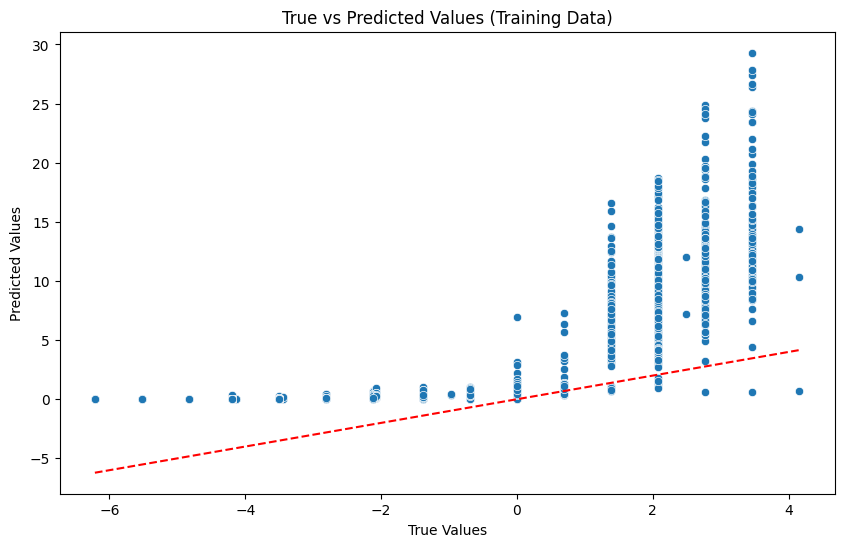

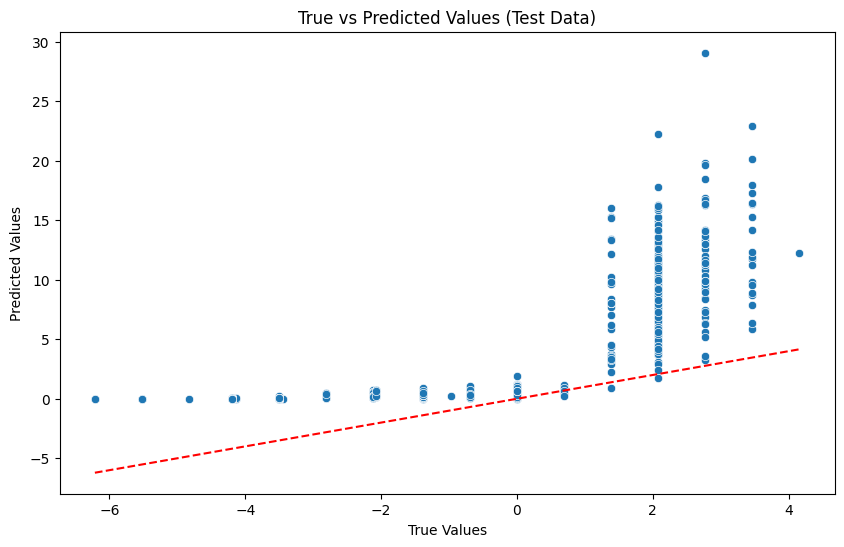

In [117]:
# Plot for training data
plot_true_vs_pred(y_train, y_pred_train, title='True vs Predicted Values (Training Data)')

# Plot for test data
plot_true_vs_pred(y_test, y_pred_test, title='True vs Predicted Values (Test Data)')


exclude_indices = [0, 5]
####Get column names
exclude_columns = to_predict.columns[exclude_indices]
dataframe_2= to_predict.drop(columns=exclude_columns)
MIC_Lab=final_model.predict(to_predict.drop)

In [118]:
def predict_with_exclusions(model, data, exclude_indices):
    """
    Make predictions on the given data using the provided model, excluding specified columns.

    Parameters:
    - model: The trained model used for making predictions.
    - data: The DataFrame containing the data to predict on.
    - exclude_indices: List of column indices to exclude.

    Returns:
    - predictions: The predictions made by the model.
    """
    # Get the column names for the indices
    exclude_columns = data.columns[exclude_indices]

    # Drop the specified columns from the DataFrame
    dataframe_2 = data.drop(columns=exclude_columns)

    # Make predictions using the model
    predictions = model.predict(dataframe_2)

    return predictions

# Example usage:
# Assuming you have a trained model `final_model` and data `to_predict`
#exclude_indices = [0,3,5]
#MIC_Lab = predict_with_exclusions(final_model, to_predict, exclude_indices)
#print(MIC_Lab)

In [189]:
#codifica variables categoricas y usalas para PREDECIR

col_1 = to_predict.iloc[:,1]
col_2 = to_predict.iloc[:,2]
#col_3 = to_predict.iloc[:,3]
col_3 =Lab_pop
col_4 = to_predict.iloc[:,4]
label_encoder = LabelEncoder()
    
    # Fit and transform the labels
col_1_encoder = label_encoder.fit_transform(col_1)
col_2_encoder = label_encoder.fit_transform(col_2)
col_3_encoder = label_encoder.fit_transform(col_3)
col_4_encoder = label_encoder.fit_transform(col_4)

to_predict["genus"]=col_1_encoder
to_predict["species"]=col_2_encoder
to_predict["phenotype"]=col_3_encoder
to_predict["antibiotic"]=col_4_encoder

In [190]:
exclude_indices = [0, 5]
MIC_Lab = predict_with_exclusions(final_model, to_predict, exclude_indices)
print(np.exp(MIC_Lab))

[0.21319933 0.19478136 0.17400755 ... 0.03039656 0.04526837 0.03189948]


In [155]:
DT["MIC"]=np.round(np.exp(MIC_Lab),3)

In [123]:
#DT[(DT["status"]=="Susceptible") & (DT["MIC"]>2)]

In [124]:
DT.to_csv(os.path.join("Resultados_Lasso", "First_prediction_Lasso.csv"), index=False)

In [158]:
print(Lab_haydee_encoded)

print(Lab_victor_encoded)
count= 0
for i in range(1820):
    if DT_hay["status"][i]==DT_vic["status"][i]:
        count=count+1
    else: count=count
print(count)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
1820


In [131]:
otras_etiquetas

,accession,genus,species,antibiotic,status,Sin_transformacion_MLP,Con tfidf MLP,PCA-svm pol,pca + tfidf,svd MLP,svd+tfidf RF1200,umap KNN5,umap+tfidf KNN5,lasso,phenotype(RForest),phenotype(SVM),phenotype
0,ERR1417717,Escherichia,coli,ciprofloxacin,EscS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1,ERR1417719,Escherichia,coli,ciprofloxacin,EscS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
2,ERR1417722,Escherichia,coli,ciprofloxacin,EscS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
3,ERR1417741,Escherichia,coli,ciprofloxacin,EscS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
4,ERR1417745,Escherichia,coli,ciprofloxacin,EscS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,SRR3242343,Salmonella,enterica,ciprofloxacin,SaeS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1816,SRR2082856,Salmonella,enterica,ciprofloxacin,SaeS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1817,SRR3242362,Salmonella,enterica,ciprofloxacin,SaeS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1818,SRR1257300,Salmonella,enterica,ciprofloxacin,SaeS,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible


In [144]:
otras_etiquetas = pd.read_csv("predicciones_actual2.csv")
Lab_haydee= otras_etiquetas["umap+tfidf KNN5"]
Lab_victor=otras_etiquetas["phenotype"]

Lab_haydee_encoded=label_encoder.fit_transform(Lab_haydee)
Lab_victor_encoded=label_encoder.fit_transform(Lab_victor)

to_predict["phenotype"]=Lab_haydee_encoded
print(to_predict["phenotype"].value_counts())
Haydee = predict_with_exclusions(final_model, to_predict, exclude_indices)
print(np.exp(Haydee))
DT["MIC"]=np.round(np.exp(Haydee),3)
DT["status"]=Lab_haydee
DT.to_csv(os.path.join("Resultados_Lasso", "Haydee.csv"), index=False)
DT_hay=DT



phenotype
1    1523
0     297
Name: count, dtype: int64
[0.21319933 0.19478136 0.17400755 ... 0.03039656 0.04526837 0.03189948]
phenotype
1    1784
0      36
Name: count, dtype: int64
[0.21319933 0.19478136 0.17400755 ... 0.03039656 0.04526837 0.03189948]


In [156]:
Lab_victor=otras_etiquetas["phenotype"]
Lab_victor_encoded=label_encoder.fit_transform(Lab_victor)
to_predict["phenotype"]=Lab_victor_encoded
print(to_predict["phenotype"].value_counts())
Victor= predict_with_exclusions(final_model, to_predict, exclude_indices)
print(np.exp(Victor))
DT["MIC"]=np.round(np.exp(Victor),3)
DT["status"]=Lab_victor
DT.to_csv(os.path.join("Resultados_Lasso", "Victor.csv"), index=False)
DT_vic=DT

phenotype
1    1784
0      36
Name: count, dtype: int64
[0.21319933 0.19478136 0.17400755 ... 0.03039656 0.04526837 0.03189948]


In [168]:
most_pop=pd.read_csv("most_pop.csv")

In [169]:
most_pop

,Sin_transformacion_MLP,Con tfidf MLP,PCA-svm pol,pca + tfidf,svd MLP,svd+tfidf RF1200,umap KNN5,umap+tfidf KNN5,lasso,phenotype(RForest),phenotype(SVM),phenotype,most_frequent_value
0,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
2,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
3,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
4,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1816,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1817,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible
1818,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible


In [185]:
Lab_pop=most_pop["most_frequent_value"]

Lab_pop_encoded=label_encoder.fit_transform(Lab_pop)
to_predict["phenotype"]=Lab_pop_encoded
print(to_predict["phenotype"].value_counts())
Pop = predict_with_exclusions(final_model, to_predict, exclude_indices)
print(np.exp(Pop))
DT["MIC"]=np.round(np.exp(Pop),3)
DT["status"]=Lab_pop
DT.to_csv(os.path.join("Resultados_Lasso", "POP.csv"), index=False)
DT_pop=DT


phenotype
1    1496
0     324
Name: count, dtype: int64
[0.21319933 0.19478136 0.17400755 ... 0.03039656 0.04526837 0.03189948]


In [20]:
np.where(y_pred_test>100)

(array([], dtype=int64),)

In [21]:
y_test[796]

KeyError: 796

In [ ]:
y_pred_continuous = modelo.predict(X_test)

In [165]:


def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model using the test data and plots the predictions vs. actual values.

    Parameters:
    - model: The trained model.
    - X_test: The test feature data.
    - y_test: The true labels for the test data.

    Returns:
    - mae: The mean absolute error of the model.
    - mse: The mean squared error of the model.
    - rmse: The root mean squared error of the model.
    - r2: The R-squared score of the model.
    """
    # Predict continuous values
    y_pred = model.predict(X_test)
    y_pred= np.exp(y_pred)
    y_test= np.exp(y_test)
    
    # Calculate regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Print the regression metrics
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    
    # Plot the predictions vs. actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title('Predictions vs. Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()
    
    return mae, mse, rmse, r2


Mean Absolute Error (MAE): 1.12
Mean Squared Error (MSE): 12.61
Root Mean Squared Error (RMSE): 3.55
R-squared (R²): 0.61


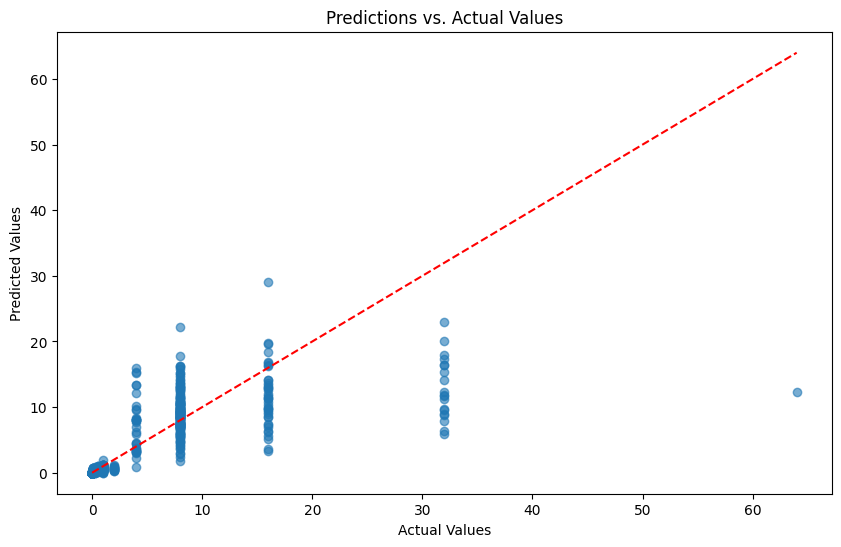

In [166]:
mae, mse, rmse, r2 = evaluate_model(final_model, X_test, y_test)
